<a href="https://colab.research.google.com/github/Nikhileswar-Komati/100D_ML/blob/master/Algorithms/Decision_Tree_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from sklearn.metrics import accuracy_score
from sklearn.model_selection import  train_test_split

In [ ]:
dataset = datasets.load_iris() 
df = pd.DataFrame(columns = dataset.feature_names, data = dataset.data)
target_zip= dict(zip(set(dataset.target), dataset.target_names))
df['target'] = dataset.target
df['target_names'] = df['target'].map(target_zip)
df.sample(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_names
130,7.4,2.8,6.1,1.9,2,virginica
3,4.6,3.1,1.5,0.2,0,setosa
22,4.6,3.6,1.0,0.2,0,setosa
89,5.5,2.5,4.0,1.3,1,versicolor
127,6.1,3.0,4.9,1.8,2,virginica


In [ ]:
X = df.iloc[:, :4]
y = df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle = True, random_state = 24)

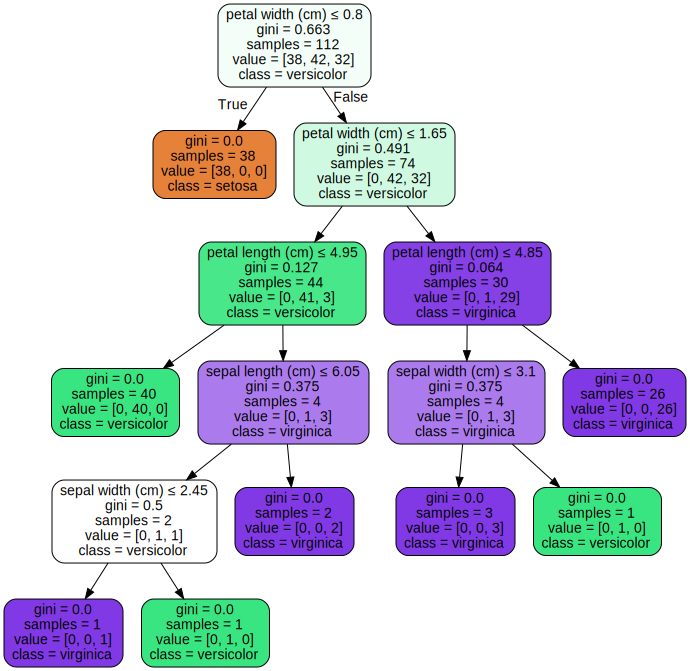

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

dot_data = export_graphviz(dt, out_file=None, 
                           feature_names=X.columns,  
                           class_names=dataset.target_names,  
                           filled=True, rounded=True,  
                           special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

In [ ]:
sklearn_y_preds = dt.predict(X_test)
print(f"Sklearn Implementation:\nACCURACY: {accuracy_score(y_test, sklearn_y_preds)}")

Sklearn Implementation:
ACCURACY: 0.9736842105263158


In [ ]:
def partition(data, column, value):
  left = data[data[column] <= value].index
  right = data[data[column] > value].index
  return left, right

In [ ]:
left_idx, right_idx = partition(X_train, "petal length (cm)", 2.45)

print("[petal length (cm) <= 2.45]")

# print results --> left_idx = 38 setosa | right index = 42 versicolor, 32 virginica 
print(f"left_idx: {dict(zip(np.unique(y_train.loc[left_idx], return_counts=True)[0], np.unique(y_train.loc[left_idx], return_counts=True)[1]))}\n\
right_idx: {dict(zip(np.unique(y_train.loc[right_idx], return_counts=True)[0], np.unique(y_train.loc[right_idx], return_counts=True)[1]))}")

[petal length (cm) <= 2.45]
left_idx: {'setosa': 38}
right_idx: {'versicolor': 42, 'virginica': 32}


In [ ]:
def gini_impurity(labels, labels_indxs):
  unq_labels, unq_labels_count = np.unique(labels.loc[labels_indxs], return_counts = True)
  impurity = 1.0
  count_of_labels = np.sum(unq_labels_count)
  for label_counts in unq_labels_count:
    p_label = label_counts / count_of_labels
    impurity -= p_label ** 2
  return impurity

In [ ]:
impurity = gini_impurity(y_train, y_train.index)
impurity

0.6626275510204082

In [ ]:
def info_gain(labels, left_idx, right_idx, impurity):
  length_left_indx = len(left_idx)
  length_right_indx = len(right_idx)
  p = length_left_indx / (length_left_indx + length_right_indx)
  information_gain = impurity - p  * gini_impurity(labels, left_idx) - (1-p)*gini_impurity(labels, right_idx)
  return information_gain

In [ ]:
# testing info gain of the first split at root node
information_gain = info_gain(y_train, left_idx, right_idx, impurity)
information_gain

0.25446843371494937

In [ ]:
# testing a random feature and value to see the information gain
left_idx, right_idx = partition(X_train, "petal width (cm)", 1.65)

impurity = gini_impurity(y_train, y_train.index)
print(impurity)
info_gain(y_train, left_idx, right_idx, impurity)

0.6626275510204082


0.25446843371494937

In [80]:
def find_best_split(df, labels, indxs):
  best_gain = 0
  best_col = None
  best_val = None
  df = df.loc[indxs]
  labels_indxs = labels.loc[indxs].index
  impurity = gini_impurity(labels, labels_indxs)
  for col in df.columns:
    for unq_val in df[col].unique():
      left_indx, right_indx = partition(df, col, unq_val)
      if len(left_indx) == 0 or len(right_idx) == 0:
        continue
      information_gain = info_gain(labels, left_indx, right_indx, impurity)
      if information_gain > best_gain:
        best_gain = information_gain
        best_col = col
        best_val = unq_val
  return best_gain, best_col, best_val


In [81]:
find_best_split(X_train, y_train, y_train.index)

(0.33830322669608387, 'petal length (cm)', 1.9)

In [82]:
def count(labels, indxs):
  unq_labels, unq_indxs = np.unique(labels.loc[indxs], return_counts=True)
  dict_label_count = dict(zip(unq_labels, unq_indxs))
  return dict_label_count

In [83]:
count(y_train, y_train.index)

{'setosa': 38, 'versicolor': 42, 'virginica': 32}

In [88]:
class Leaf:
  def __init__(self, labels, indxs):
    self.predictions = count(labels, indxs)

class Node:
  def __init__(self, column, value, true_branch, false_branch):
    self.column = column
    self.value = value
    self.true_branch = true_branch
    self.false_branch = false_branch

def print_tree(node, spacing = ""):
  if isinstance(node, Leaf):
    print(spacing + "Predict", node.predictions)
    return 
  print(spacing + f"[{node.column} <= {node.value}]")   

  # Call this function recursively on the true branch
  print(spacing + '--> True:')
  print_tree(node.true_branch, spacing + "  ")

  # Call this function recursively on the false branch
  print(spacing + '--> False:')
  print_tree(node.false_branch, spacing + "  ") 

In [89]:
def build_tree(df, labels, indxs):
  best_gain, best_col, best_value = find_best_split(df, labels, indxs)
  if best_gain == 0: 
        return Leaf(labels, labels.loc[indxs].index)
  left_indx, right_indx = partition(df.loc[indxs], best_col, best_value)

  true_branch = build_tree(df, labels, left_indx)
  false_branch = build_tree(df, labels, right_indx)

  return Node(best_col, best_value, true_branch, false_branch)

my_tree = build_tree(X_train, y_train, X_train.index)
print_tree(my_tree)

[petal length (cm) <= 1.9]
--> True:
  Predict {'setosa': 38}
--> False:
  [petal width (cm) <= 1.6]
  --> True:
    [petal length (cm) <= 4.9]
    --> True:
      Predict {'versicolor': 40}
    --> False:
      [sepal length (cm) <= 6.0]
      --> True:
        [sepal width (cm) <= 2.2]
        --> True:
          Predict {'virginica': 1}
        --> False:
          Predict {'versicolor': 1}
      --> False:
        Predict {'virginica': 2}
  --> False:
    [petal length (cm) <= 4.8]
    --> True:
      [sepal width (cm) <= 3.0]
      --> True:
        Predict {'virginica': 3}
      --> False:
        Predict {'versicolor': 1}
    --> False:
      Predict {'virginica': 26}


In [90]:
def predict(test_data, tree):
    
    """
    Classify unseen examples
    
    Inputs
    test_data: Unseen observation
    tree: tree that has been trained on training data
    
    Output
    The prediction of the observation.
    """
    
    # Check if we are at a leaf node
    if isinstance(tree, Leaf): 
        return max(tree.predictions)
    
    # the current feature_name and value 
    feature_name, feature_value = tree.column, tree.value
    
    # pass the observation through the nodes recursively
    if test_data[feature_name] <= feature_value: 
        return predict(test_data, tree.true_branch)
    
    else: 
        return predict(test_data, tree.false_branch)

In [92]:
# taking one instance to test function 
example, example_target = X_test.iloc[6], y_test.iloc[6]
example, example_target
predict(example, my_tree)

'setosa'

In [93]:
X_test["predictions"] = X_test.apply(predict, axis=1, args=(my_tree,))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [94]:
print(f"Sklearn Implementation:\nACCURACY: {accuracy_score(y_test, sklearn_y_preds)}\n\n\
My Implementation:\nACCURACY: {accuracy_score(y_test, X_test['predictions'])}")

Sklearn Implementation:
ACCURACY: 0.9736842105263158

My Implementation:
ACCURACY: 0.9736842105263158
